# Economic Indicator Analysis

The goal of this project was to create a classification preditive model that could predict an upcoming recession. Ideally, this classification model would be able to do so before the markets had priced in the recession. The features in the predictive algorithms were economic metrics, including inflation, GDP growth, and unemployment rate, as well as stock and treasury market data, including LTM S&P 500 return, short term treasury yields, and various treasury yield curve spreads. However, the resulting models were unable to accomplish the goal. Despite having very predictive accuracy (>90%), none of the models outperformed the zero rate, which was used as a baseline evaluation rate. This forced the conclusion that none of the classification models were useful since each was less accurate that merely always predicting the most common forward recession classification.  

## Import Libaries

In [1736]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("ggplot") 
from datetime import datetime, timedelta, date
import yfinance as yf

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

## Import Economic Data into Dataframe

In [1737]:
!pip install fredapi

In [1738]:
from fredapi import Fred

fred_api_key = "f8f17d6a6cd348400a30a77bbcc4c14a"
fred = Fred(api_key = fred_api_key)

In [1739]:
df_core_cpi = fred.get_series_latest_release("CPIAUCSL").to_frame()
df_core_cpi.reset_index(inplace = True)
df_core_cpi.rename(columns = {"index":"Date", 0:"Core_CPI"}, inplace = True)

df_cpi = fred.get_series_latest_release("CPILFESL").to_frame()
df_cpi.reset_index(inplace = True)
df_cpi.rename(columns = {"index":"Date", 0:"CPI"}, inplace = True)

df_gdp = fred.get_series_latest_release("GDP").to_frame()
df_gdp.reset_index(inplace = True)
df_gdp.rename(columns = {"index":"Date", 0:"GDP"}, inplace = True)

df_unrate = fred.get_series_latest_release("UNRATE").to_frame()
df_unrate.reset_index(inplace = True)
df_unrate.rename(columns = {"index":"Date", 0:"UNRATE"}, inplace = True)

In [1740]:
df_fred = pd.DataFrame(columns = ["Date"])
df_fred["Date"] = pd.date_range("1977-02-15", datetime.now(), freq = "D")

In [1741]:
df_fred = pd.merge(df_fred, df_core_cpi, on = "Date", how = "left")
df_fred = pd.merge(df_fred, df_cpi, on = "Date", how = "left")
df_fred = pd.merge(df_fred, df_gdp, on = "Date", how = "left")
df_fred = pd.merge(df_fred, df_unrate, on = "Date", how = "left")

In [1742]:
df_fred.head()

,Date,Core_CPI,CPI,GDP,UNRATE
0,1977-02-15,NaN,NaN,NaN,NaN
1,1977-02-16,NaN,NaN,NaN,NaN
2,1977-02-17,NaN,NaN,NaN,NaN
3,1977-02-18,NaN,NaN,NaN,NaN
4,1977-02-19,NaN,NaN,NaN,NaN


## Import Market Data into Dataframe

In [1743]:
startdate = "1977-02-15"
enddate = datetime.now().strftime("%Y-%m-%d")

df_yf = yf.download(["^GSPC", "^IRX", "^FVX", "^TNX", "^TYX"], 
                 start = startdate, end = enddate, group_by = "ticker")

[*********************100%***********************]  5 of 5 completed


In [1744]:
SP500 = df_yf["^GSPC", "Close"].values
T3M = df_yf["^IRX", "Close"].values
T5Y = df_yf["^FVX", "Close"].values
T10Y = df_yf["^TNX", "Close"].values
T30Y = df_yf["^TYX", "Close"].values
Date = df_yf.index.values

In [1745]:
df_yf = pd.DataFrame(columns = ["Date", "SP500", "T3M", "T5Y", "T10Y", "T30Y"])
df_yf["Date"], df_yf["SP500"], df_yf["T3M"], df_yf["T5Y"], df_yf["T10Y"], df_yf["T30Y"] = Date, SP500, T3M, T5Y, T10Y, T30Y

df_yf.dropna(inplace = True)
df_yf.reset_index(inplace = True, drop = True)

df_yf.head()

,Date,SP500,T3M,T5Y,T10Y,T30Y
0,1977-02-15,101.040001,4.63,6.72,7.36,7.70
1,1977-02-16,101.500000,4.62,6.70,7.34,7.67
2,1977-02-17,100.919998,4.61,6.67,7.26,7.67
3,1977-02-18,100.489998,4.66,6.82,7.41,7.76
4,1977-02-22,100.489998,4.69,6.84,7.42,7.77


## Merge Dataframes

In [1746]:
df = pd.DataFrame(columns = ["Date"])
df["Date"] = pd.date_range(startdate, datetime.now(), freq = "D")

In [1747]:
df = pd.merge(df, df_fred, on = "Date", how = "left")
df = pd.merge(df, df_yf, on = "Date", how = "left")

In [1748]:
df.head()

,Date,Core_CPI,CPI,GDP,UNRATE,SP500,T3M,T5Y,T10Y,T30Y
0,1977-02-15,NaN,NaN,NaN,NaN,101.040001,4.63,6.72,7.36,7.70
1,1977-02-16,NaN,NaN,NaN,NaN,101.500000,4.62,6.70,7.34,7.67
2,1977-02-17,NaN,NaN,NaN,NaN,100.919998,4.61,6.67,7.26,7.67
3,1977-02-18,NaN,NaN,NaN,NaN,100.489998,4.66,6.82,7.41,7.76
4,1977-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Wrangling and Feature Engineering

#### Fill in Quarterly Economic Data

In [1749]:
df[["Core_CPI"]] = df["Core_CPI"].fillna(method = "ffill")
df[["CPI"]] = df["CPI"].fillna(method = "ffill")
df[["GDP"]] = df["GDP"].fillna(method = "ffill")
df[["UNRATE"]] = df["UNRATE"].fillna(method = "ffill")

In [1750]:
df.head()

,Date,Core_CPI,CPI,GDP,UNRATE,SP500,T3M,T5Y,T10Y,T30Y
0,1977-02-15,NaN,NaN,NaN,NaN,101.040001,4.63,6.72,7.36,7.70
1,1977-02-16,NaN,NaN,NaN,NaN,101.500000,4.62,6.70,7.34,7.67
2,1977-02-17,NaN,NaN,NaN,NaN,100.919998,4.61,6.67,7.26,7.67
3,1977-02-18,NaN,NaN,NaN,NaN,100.489998,4.66,6.82,7.41,7.76
4,1977-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Add New Features

In [1751]:
from dateutil.relativedelta import relativedelta

df["Core_Inf"] = np.zeros(len(df))
df["Inf"] = np.zeros(len(df))
df["YoY_GDP_Growth"] = np.zeros(len(df))
df["LTM_SP_Return"] = np.zeros(len(df))

for i in range(len(df)):
    
    if i > 365:
        
        today_date = df.loc[i, "Date"]
        today_idx = df[df["Date"] == today_date].index[0]
    
        last_year_date = today_date - relativedelta(years = 1)
        last_year_idx = df[df["Date"] == last_year_date].index[0]
    
        df.loc[today_idx, "Core_Inf"] = ((df.loc[today_idx, "Core_CPI"] - df.loc[last_year_idx, "Core_CPI"]) / df.loc[last_year_idx, "Core_CPI"]) * 100
        df.loc[today_idx, "Inf"] = ((df.loc[today_idx, "CPI"] - df.loc[last_year_idx, "CPI"]) / df.loc[last_year_idx, "CPI"]) * 100
        df.loc[today_idx, "YoY_GDP_Growth"] = ((df.loc[today_idx, "GDP"] - df.loc[last_year_idx, "GDP"]) / df.loc[last_year_idx, "GDP"]) * 100
        df.loc[today_idx, "LTM_SP_Return"] = ((df.loc[today_idx, "SP500"] - df.loc[last_year_idx, "SP500"]) / df.loc[last_year_idx, "SP500"]) * 100

In [1752]:
df = df[366:]
df.head()

,Date,Core_CPI,CPI,GDP,UNRATE,SP500,T3M,T5Y,T10Y,T30Y,Core_Inf,Inf,YoY_GDP_Growth,LTM_SP_Return
366,1978-02-16,63.0,63.4,2202.76,6.3,88.080002,6.51,7.90,8.10,8.30,NaN,NaN,NaN,-13.221673
367,1978-02-17,63.0,63.4,2202.76,6.3,87.959999,6.45,7.88,8.09,8.29,NaN,NaN,NaN,-12.841854
368,1978-02-18,63.0,63.4,2202.76,6.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369,1978-02-19,63.0,63.4,2202.76,6.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
370,1978-02-20,63.0,63.4,2202.76,6.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1753]:
df.dropna(inplace = True)
df.reset_index(inplace = True, drop = True)
df.head()

,Date,Core_CPI,CPI,GDP,UNRATE,SP500,T3M,T5Y,T10Y,T30Y,Core_Inf,Inf,YoY_GDP_Growth,LTM_SP_Return
0,1978-04-04,63.9,64.3,2331.633,6.1,88.860001,6.39,7.95,8.12,8.31,6.5,6.633499,13.411294,-9.538840
1,1978-04-05,63.9,64.3,2331.633,6.1,89.639999,6.42,7.97,8.14,8.32,6.5,6.633499,13.411294,-8.539948
2,1978-04-06,63.9,64.3,2331.633,6.1,89.790001,6.41,7.98,8.16,8.33,6.5,6.633499,13.411294,-8.293333
3,1978-04-07,63.9,64.3,2331.633,6.1,90.169998,6.34,7.97,8.14,8.34,6.5,6.633499,13.411294,-8.317235
4,1978-04-11,63.9,64.3,2331.633,6.1,90.250000,6.35,7.97,8.16,8.35,6.5,6.633499,13.411294,-8.727748


In [1754]:
df["T5Y-T3M"] = df["T5Y"] - df["T3M"]
df["T10Y-T3M"] = df["T10Y"] - df["T3M"]
df["T30Y-T3M"] = df["T30Y"] - df["T3M"]
df["SP_Return"] = df["SP500"].pct_change() * 100

In [1755]:
df.dropna(inplace = True)
df.reset_index(inplace = True, drop = True)
df.head()

,Date,Core_CPI,CPI,GDP,UNRATE,SP500,T3M,T5Y,T10Y,T30Y,Core_Inf,Inf,YoY_GDP_Growth,LTM_SP_Return,T5Y-T3M,T10Y-T3M,T30Y-T3M,SP_Return
0,1978-04-05,63.9,64.3,2331.633,6.1,89.639999,6.42,7.97,8.14,8.32,6.5,6.633499,13.411294,-8.539948,1.55,1.72,1.90,0.877784
1,1978-04-06,63.9,64.3,2331.633,6.1,89.790001,6.41,7.98,8.16,8.33,6.5,6.633499,13.411294,-8.293333,1.57,1.75,1.92,0.167338
2,1978-04-07,63.9,64.3,2331.633,6.1,90.169998,6.34,7.97,8.14,8.34,6.5,6.633499,13.411294,-8.317235,1.63,1.80,2.00,0.423207
3,1978-04-11,63.9,64.3,2331.633,6.1,90.250000,6.35,7.97,8.16,8.35,6.5,6.633499,13.411294,-8.727748,1.62,1.81,2.00,0.088723
4,1978-04-12,63.9,64.3,2331.633,6.1,90.110001,6.33,7.97,8.16,8.35,6.5,6.633499,13.411294,-10.024963,1.64,1.83,2.02,-0.155124


#### Check for Null, Zero, and Duplicate Rows

In [1756]:
# Null Values
df.isnull().sum()

Date              0
Core_CPI          0
CPI               0
GDP               0
UNRATE            0
SP500             0
T3M               0
T5Y               0
T10Y              0
T30Y              0
Core_Inf          0
Inf               0
YoY_GDP_Growth    0
LTM_SP_Return     0
T5Y-T3M           0
T10Y-T3M          0
T30Y-T3M          0
SP_Return         0
dtype: int64

In [1757]:
# Datatypes
df.dtypes

Date              datetime64[ns]
Core_CPI                 float64
CPI                      float64
GDP                      float64
UNRATE                   float64
SP500                    float64
T3M                      float64
T5Y                      float64
T10Y                     float64
T30Y                     float64
Core_Inf                 float64
Inf                      float64
YoY_GDP_Growth           float64
LTM_SP_Return            float64
T5Y-T3M                  float64
T10Y-T3M                 float64
T30Y-T3M                 float64
SP_Return                float64
dtype: object

In [1758]:
# Zero Values
for col in df.columns:
    print(col, (df[col] == 0).sum())

Date 0
Core_CPI 0
CPI 0
GDP 0
UNRATE 0
SP500 0
T3M 0
T5Y 0
T10Y 0
T30Y 0
Core_Inf 0
Inf 0
YoY_GDP_Growth 0
LTM_SP_Return 0
T5Y-T3M 6
T10Y-T3M 7
T30Y-T3M 5
SP_Return 11


In [1759]:
zeros = df[(df["T10Y-T3M"] == 0) | (df["SP_Return"] == 0)].index.values

for i in zeros:
    print(df.loc[i-2:i+1, ["Date", "T3M", "T10Y", "T10Y-T3M", "SP500", "SP_Return"]])
    print("")

          Date   T3M  T10Y  T10Y-T3M      SP500  SP_Return
214 1979-05-09  9.64  9.36 -0.280001  99.459999   0.292428
215 1979-05-10  9.64  9.36 -0.280001  98.519997  -0.945106
216 1979-05-11  9.56  9.34 -0.220000  98.519997   0.000000
217 1979-05-15  9.60  9.32 -0.280001  98.139999  -0.385706

          Date   T3M  T10Y  T10Y-T3M       SP500  SP_Return
234 1979-06-15  9.15  8.96     -0.19  102.089996  -0.107633
235 1979-06-19  8.97  8.95     -0.02  101.580002  -0.499554
236 1979-06-20  8.94  8.94      0.00  101.629997   0.049218
237 1979-06-21  8.96  8.93     -0.03  102.089996   0.452621

          Date   T3M  T10Y  T10Y-T3M       SP500  SP_Return
255 1979-07-25  9.22  8.99 -0.230000  103.080002   1.088556
256 1979-07-26  9.13  8.97 -0.160000  103.099998   0.019399
257 1979-07-27  9.23  9.02 -0.209999  103.099998   0.000000
258 1979-07-31  9.18  9.01 -0.170000  103.809998   0.688651

          Date   T3M  T10Y  T10Y-T3M       SP500  SP_Return
273 1979-08-24  9.64  9.14     -0.50  108.

In [1760]:
# Duplicate Rows
df["Date"].value_counts().max()

1

In [1761]:
df.head()

,Date,Core_CPI,CPI,GDP,UNRATE,SP500,T3M,T5Y,T10Y,T30Y,Core_Inf,Inf,YoY_GDP_Growth,LTM_SP_Return,T5Y-T3M,T10Y-T3M,T30Y-T3M,SP_Return
0,1978-04-05,63.9,64.3,2331.633,6.1,89.639999,6.42,7.97,8.14,8.32,6.5,6.633499,13.411294,-8.539948,1.55,1.72,1.90,0.877784
1,1978-04-06,63.9,64.3,2331.633,6.1,89.790001,6.41,7.98,8.16,8.33,6.5,6.633499,13.411294,-8.293333,1.57,1.75,1.92,0.167338
2,1978-04-07,63.9,64.3,2331.633,6.1,90.169998,6.34,7.97,8.14,8.34,6.5,6.633499,13.411294,-8.317235,1.63,1.80,2.00,0.423207
3,1978-04-11,63.9,64.3,2331.633,6.1,90.250000,6.35,7.97,8.16,8.35,6.5,6.633499,13.411294,-8.727748,1.62,1.81,2.00,0.088723
4,1978-04-12,63.9,64.3,2331.633,6.1,90.110001,6.33,7.97,8.16,8.35,6.5,6.633499,13.411294,-10.024963,1.64,1.83,2.02,-0.155124


#### Merge Recession Indicator

In [1762]:
df_rec = fred.get_series_latest_release("USREC").to_frame()
df_rec.reset_index(inplace = True)
df_rec.rename(columns = {"index":"Date", 0:"Recession"}, inplace = True)

In [1763]:
df = pd.merge(df, df_rec, on = "Date", how = "left")

<AxesSubplot:xlabel='Date', ylabel='Recession'>

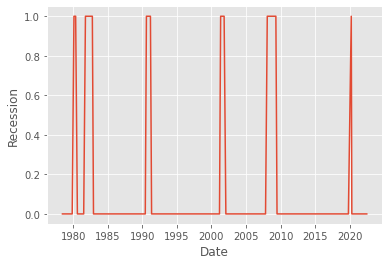

In [1764]:
sns.lineplot(data = df, x = "Date", y = "Recession")

In [1765]:
df["Recession"] = df["Recession"].fillna(method = "bfill")

<AxesSubplot:xlabel='Date', ylabel='Recession'>

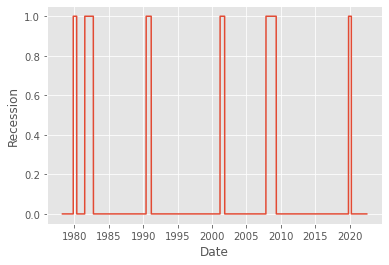

In [1766]:
sns.lineplot(data = df, x = "Date", y = "Recession")

In [1767]:
df["Recession"] = df["Recession"].fillna(method = "ffill")

In [1768]:
df[(df["Date"] > pd.Timestamp(2019, 10, 31)) & (df["Date"] < pd.Timestamp(2020, 4, 3))]

,Date,Core_CPI,CPI,GDP,UNRATE,SP500,T3M,T5Y,T10Y,T30Y,Core_Inf,Inf,YoY_GDP_Growth,LTM_SP_Return,T5Y-T3M,T10Y-T3M,T30Y-T3M,SP_Return,Recession
7703,2019-11-01,257.788,265.461,21694.458,3.6,3066.909912,1.485,1.554,1.728,2.212,2.030816,2.314852,4.233504,11.915901,0.069,0.243,0.727,0.966231,0.0
7704,2019-11-05,257.788,265.461,21694.458,3.6,3074.620117,1.518,1.671,1.866,2.348,2.030816,2.314852,4.233504,12.281665,0.153,0.348,0.830,0.251400,1.0
7705,2019-11-06,257.788,265.461,21694.458,3.6,3076.780029,1.515,1.628,1.814,2.297,2.030816,2.314852,4.233504,11.661619,0.113,0.299,0.782,0.070250,1.0
7706,2019-11-07,257.788,265.461,21694.458,3.6,3085.179932,1.518,1.740,1.926,2.403,2.030816,2.314852,4.233504,9.641104,0.222,0.408,0.885,0.273010,1.0
7707,2019-11-08,257.788,265.461,21694.458,3.6,3093.080078,1.510,1.734,1.933,2.417,2.030816,2.314852,4.233504,10.198337,0.224,0.423,0.907,0.256068,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7774,2020-03-25,258.165,266.916,21481.367,4.4,2475.560059,-0.070,0.521,0.858,1.423,1.530638,2.117208,2.284475,-11.535329,0.591,0.928,1.493,7.403300,1.0
7775,2020-03-26,258.165,266.916,21481.367,4.4,2630.070068,-0.105,0.478,0.811,1.395,1.530638,2.117208,2.284475,-6.684143,0.583,0.916,1.500,6.241416,1.0
7776,2020-03-27,258.165,266.916,21481.367,4.4,2541.469971,-0.058,0.426,0.749,1.337,1.530638,2.117208,2.284475,-9.406964,0.484,0.807,1.395,-3.368735,1.0
7777,2020-04-01,256.094,265.771,19477.444,14.7,2470.500000,0.063,0.369,0.635,1.289,0.364865,1.455577,-8.510504,-13.835496,0.306,0.572,1.226,-2.792477,1.0


In [1769]:
df[["Date", "UNRATE", "Core_Inf", "YoY_GDP_Growth", "T3M", "T5Y-T3M", "T10Y-T3M", "T30Y-T3M", "LTM_SP_Return", "Recession"]]

,Date,UNRATE,Core_Inf,YoY_GDP_Growth,T3M,T5Y-T3M,T10Y-T3M,T30Y-T3M,LTM_SP_Return,Recession
0,1978-04-05,6.1,6.500000,13.411294,6.420,1.550,1.720,1.900,-8.539948,0.0
1,1978-04-06,6.1,6.500000,13.411294,6.410,1.570,1.750,1.920,-8.293333,0.0
2,1978-04-07,6.1,6.500000,13.411294,6.340,1.630,1.800,2.000,-8.317235,0.0
3,1978-04-11,6.1,6.500000,13.411294,6.350,1.620,1.810,2.000,-8.727748,0.0
4,1978-04-12,6.1,6.500000,13.411294,6.330,1.640,1.830,2.020,-10.024963,0.0
...,...,...,...,...,...,...,...,...,...,...
8210,2022-08-24,3.5,8.121439,7.242949,2.713,0.518,0.393,0.608,-7.700451,0.0
8211,2022-08-25,3.5,8.121439,7.242949,2.730,0.427,0.296,0.504,-6.607146,0.0
8212,2022-08-26,3.5,8.121439,7.242949,2.755,0.440,0.280,0.450,-9.224610,0.0
8213,2022-08-30,3.5,8.121439,7.242949,2.873,0.404,0.237,0.347,-11.981790,0.0


#### Visualize Data

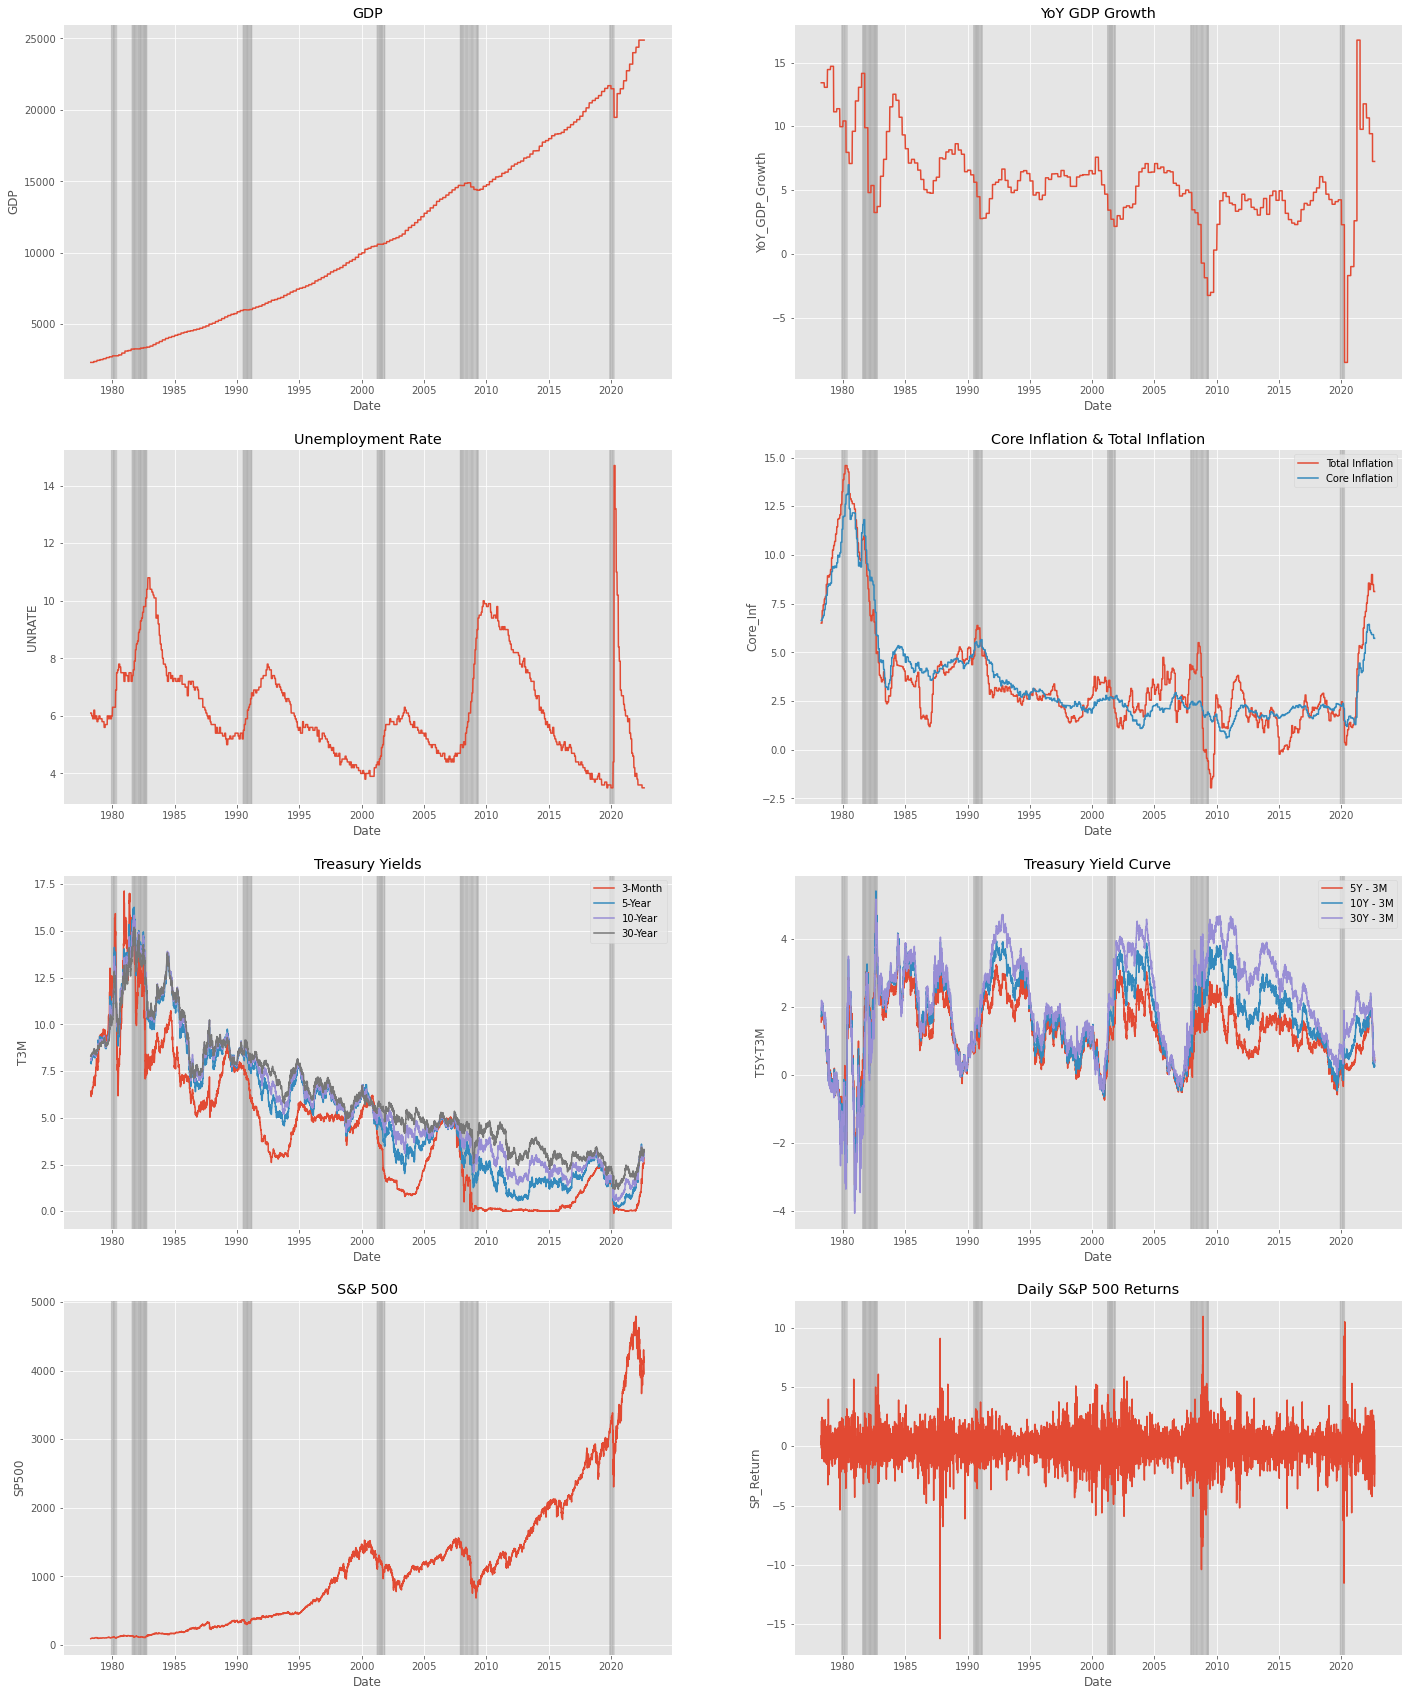

In [1770]:
rec_dates = df[df["Recession"] == 1]["Date"]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 2, figsize = (24, 30))

sns.lineplot(data = df, x = "Date", y = "GDP", ax = ax1[0])
ax1[0].set_title("GDP")

for date in rec_dates:
    ax1[0].axvspan(date, date + timedelta(days = 1), color = "grey", alpha = 0.05)

sns.lineplot(data = df, x = "Date", y = "YoY_GDP_Growth", ax = ax1[1])
ax1[1].set_title("YoY GDP Growth")

for date in rec_dates:
    ax1[1].axvspan(date, date + timedelta(days = 1), color = "grey", alpha = 0.05)

sns.lineplot(data = df, x = "Date", y = "UNRATE", ax = ax2[0])
ax2[0].set_title("Unemployment Rate")

for date in rec_dates:
    ax2[0].axvspan(date, date + timedelta(days = 1), color = "grey", alpha = 0.05)

sns.lineplot(data = df, x = "Date", y = "Core_Inf", ax = ax2[1])
sns.lineplot(data = df, x = "Date", y = "Inf", ax = ax2[1])
ax2[1].legend(labels = ["Total Inflation", "Core Inflation"])
ax2[1].set_title("Core Inflation & Total Inflation")

for date in rec_dates:
    ax2[1].axvspan(date, date + timedelta(days = 1), color = "grey", alpha = 0.05)
    
sns.lineplot(data = df, x = "Date", y = "T3M", ax = ax3[0])
sns.lineplot(data = df, x = "Date", y = "T5Y", ax = ax3[0])
sns.lineplot(data = df, x = "Date", y = "T10Y", ax = ax3[0])
sns.lineplot(data = df, x = "Date", y = "T30Y", ax = ax3[0])
ax3[0].legend(labels = ["3-Month", "5-Year", "10-Year", "30-Year"])
ax3[0].set_title("Treasury Yields")

for date in rec_dates:
    ax3[0].axvspan(date, date + timedelta(days = 1), color = "grey", alpha = 0.05)


sns.lineplot(data = df, x = "Date", y = "T5Y-T3M", ax = ax3[1])
sns.lineplot(data = df, x = "Date", y = "T10Y-T3M", ax = ax3[1])
sns.lineplot(data = df, x = "Date", y = "T30Y-T3M", ax = ax3[1])
ax3[1].legend(labels = ["5Y - 3M", "10Y - 3M", "30Y - 3M"])
ax3[1].set_title("Treasury Yield Curve")

for date in rec_dates:
    ax3[1].axvspan(date, date + timedelta(days = 1), color = "grey", alpha = 0.05)
    
sns.lineplot(data = df, x = "Date", y = "SP500", ax = ax4[0])
ax4[0].set_title("S&P 500")

for date in rec_dates:
    ax4[0].axvspan(date, date + timedelta(days = 1), color = "grey", alpha = 0.05)

sns.lineplot(data = df, x = "Date", y = "SP_Return", ax = ax4[1])
ax4[1].set_title("Daily S&P 500 Returns")

for date in rec_dates:
    ax4[1].axvspan(date, date + timedelta(days = 1), color = "grey", alpha = 0.05)

In [1771]:
df.head()

,Date,Core_CPI,CPI,GDP,UNRATE,SP500,T3M,T5Y,T10Y,T30Y,Core_Inf,Inf,YoY_GDP_Growth,LTM_SP_Return,T5Y-T3M,T10Y-T3M,T30Y-T3M,SP_Return,Recession
0,1978-04-05,63.9,64.3,2331.633,6.1,89.639999,6.42,7.97,8.14,8.32,6.5,6.633499,13.411294,-8.539948,1.55,1.72,1.90,0.877784,0.0
1,1978-04-06,63.9,64.3,2331.633,6.1,89.790001,6.41,7.98,8.16,8.33,6.5,6.633499,13.411294,-8.293333,1.57,1.75,1.92,0.167338,0.0
2,1978-04-07,63.9,64.3,2331.633,6.1,90.169998,6.34,7.97,8.14,8.34,6.5,6.633499,13.411294,-8.317235,1.63,1.80,2.00,0.423207,0.0
3,1978-04-11,63.9,64.3,2331.633,6.1,90.250000,6.35,7.97,8.16,8.35,6.5,6.633499,13.411294,-8.727748,1.62,1.81,2.00,0.088723,0.0
4,1978-04-12,63.9,64.3,2331.633,6.1,90.110001,6.33,7.97,8.16,8.35,6.5,6.633499,13.411294,-10.024963,1.64,1.83,2.02,-0.155124,0.0


#### Create 1-Month, 3-Month, and 1-Year Forward Recession Indicators
Indicator will show whether or not there is a recession after the minimum recession time has passed

In [1772]:
min_rec = len(df[(df["Date"] > pd.Timestamp(2019, 11, 1)) & (df["Date"] < pd.Timestamp(2020, 4, 2))])
min_rec

74

In [1773]:
df["Future_Recession_3M"] = np.zeros(len(df))

for i in range(len(df)):
    
    future_rec_idx = i + min_rec
    
    if i <= (df.index.max() - min_rec):
        df.loc[i, "Future_Recession_3M"] = df.loc[future_rec_idx, "Recession"]
    else:
        df.loc[i, "Future_Recession_3M"] = np.nan

In [1774]:
df["Future_Recession_3M"].value_counts()

0.0    7211
1.0     930
Name: Future_Recession_3M, dtype: int64

In [1775]:
df["Future_Recession_1M"] = np.zeros(len(df))
df["Future_Recession_1Y"] = np.zeros(len(df))

for i in range(len(df)):
    
    try:
        
        today_date = df.loc[i, "Date"]
        
        next_year_date = today_date + relativedelta(years = 1)
        next_year_idx = df[df["Date"] == next_year_date].index[0]
        df.loc[i, "Future_Recession_1Y"] = df.loc[next_year_idx, "Recession"]
        
        next_month_date = today_date + relativedelta(months = 1)
        next_month_idx = df[df["Date"] == next_month_date].index[0]
        df.loc[i, "Future_Recession_1M"] = df.loc[next_month_idx, "Recession"]
        
    except:
        df.loc[i, "Future_Recession_1M"] = np.nan

In [1776]:
df["Future_Recession_1Y"].value_counts()

0.0    7629
1.0     586
Name: Future_Recession_1Y, dtype: int64

In [1777]:
df["Future_Recession_1M"].value_counts()

0.0    2141
1.0     271
Name: Future_Recession_1M, dtype: int64

In [1778]:
df[(df["Date"] > pd.Timestamp(2019, 10, 25)) & (df["Date"] < pd.Timestamp(2020, 4, 2))]

,Date,Core_CPI,CPI,GDP,UNRATE,SP500,T3M,T5Y,T10Y,T30Y,Core_Inf,Inf,YoY_GDP_Growth,LTM_SP_Return,T5Y-T3M,T10Y-T3M,T30Y-T3M,SP_Return,Recession,Future_Recession_3M,Future_Recession_1M,Future_Recession_1Y
7700,2019-10-29,257.305,265.019,21694.458,3.6,3036.889893,1.595,1.659,1.835,2.330,1.757085,2.325123,4.233504,14.979267,0.064,0.240,0.735,0.474429,0.0,1.0,1.0,0.0
7701,2019-10-30,257.305,265.019,21694.458,3.6,3046.770020,1.595,1.637,1.798,2.272,1.757085,2.325123,4.233504,13.573998,0.042,0.203,0.677,0.325337,0.0,1.0,NaN,0.0
7702,2019-10-31,257.305,265.019,21694.458,3.6,3037.560059,1.498,1.523,1.691,2.176,1.757085,2.325123,4.233504,12.015166,0.025,0.193,0.678,-0.302286,0.0,1.0,NaN,0.0
7703,2019-11-01,257.788,265.461,21694.458,3.6,3066.909912,1.485,1.554,1.728,2.212,2.030816,2.314852,4.233504,11.915901,0.069,0.243,0.727,0.966231,0.0,1.0,NaN,0.0
7704,2019-11-05,257.788,265.461,21694.458,3.6,3074.620117,1.518,1.671,1.866,2.348,2.030816,2.314852,4.233504,12.281665,0.153,0.348,0.830,0.251400,1.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7773,2020-03-20,258.165,266.916,21481.367,4.4,2304.919922,-0.033,0.520,0.938,1.556,1.530638,2.117208,2.284475,-18.387669,0.553,0.971,1.589,-4.335951,1.0,0.0,NaN,0.0
7774,2020-03-25,258.165,266.916,21481.367,4.4,2475.560059,-0.070,0.521,0.858,1.423,1.530638,2.117208,2.284475,-11.535329,0.591,0.928,1.493,7.403300,1.0,0.0,NaN,0.0
7775,2020-03-26,258.165,266.916,21481.367,4.4,2630.070068,-0.105,0.478,0.811,1.395,1.530638,2.117208,2.284475,-6.684143,0.583,0.916,1.500,6.241416,1.0,0.0,NaN,0.0
7776,2020-03-27,258.165,266.916,21481.367,4.4,2541.469971,-0.058,0.426,0.749,1.337,1.530638,2.117208,2.284475,-9.406964,0.484,0.807,1.395,-3.368735,1.0,0.0,NaN,0.0


#### Create Numeric Date Column

In [1779]:
df["Date_Num"] = np.zeros(len(df))

for i in range(len(df)):
    if i == 0:
        df.loc[i, "Date_Num"] = 0
    else:
        df.loc[i, "Date_Num"] = (df.loc[i, "Date"] - df.loc[0, "Date"]).days

In [1780]:
df.head()

,Date,Core_CPI,CPI,GDP,UNRATE,SP500,T3M,T5Y,T10Y,T30Y,Core_Inf,Inf,YoY_GDP_Growth,LTM_SP_Return,T5Y-T3M,T10Y-T3M,T30Y-T3M,SP_Return,Recession,Future_Recession_3M,Future_Recession_1M,Future_Recession_1Y,Date_Num
0,1978-04-05,63.9,64.3,2331.633,6.1,89.639999,6.42,7.97,8.14,8.32,6.5,6.633499,13.411294,-8.539948,1.55,1.72,1.90,0.877784,0.0,0.0,0.0,0.0,0.0
1,1978-04-06,63.9,64.3,2331.633,6.1,89.790001,6.41,7.98,8.16,8.33,6.5,6.633499,13.411294,-8.293333,1.57,1.75,1.92,0.167338,0.0,0.0,NaN,0.0,1.0
2,1978-04-07,63.9,64.3,2331.633,6.1,90.169998,6.34,7.97,8.14,8.34,6.5,6.633499,13.411294,-8.317235,1.63,1.80,2.00,0.423207,0.0,0.0,NaN,0.0,2.0
3,1978-04-11,63.9,64.3,2331.633,6.1,90.250000,6.35,7.97,8.16,8.35,6.5,6.633499,13.411294,-8.727748,1.62,1.81,2.00,0.088723,0.0,0.0,0.0,0.0,6.0
4,1978-04-12,63.9,64.3,2331.633,6.1,90.110001,6.33,7.97,8.16,8.35,6.5,6.633499,13.411294,-10.024963,1.64,1.83,2.02,-0.155124,0.0,0.0,0.0,0.0,7.0


#### Feature Reduction

In [1781]:
df.corr()["Future_Recession_3M"].sort_values(ascending = False)

Future_Recession_3M    1.000000
Future_Recession_1M    0.567727
Recession              0.461008
Core_Inf               0.331182
T3M                    0.304040
Inf                    0.292962
T5Y                    0.236067
T10Y                   0.222261
T30Y                   0.208368
Future_Recession_1Y    0.204774
YoY_GDP_Growth         0.094068
SP_Return             -0.043596
UNRATE                -0.079262
SP500                 -0.088280
GDP                   -0.105620
Core_CPI              -0.122027
Date_Num              -0.132850
CPI                   -0.135094
LTM_SP_Return         -0.224885
T5Y-T3M               -0.257644
T10Y-T3M              -0.290656
T30Y-T3M              -0.319376
Name: Future_Recession_3M, dtype: float64

In [1786]:
df1 = df[["Date", "Date_Num", "Recession", "YoY_GDP_Growth", "UNRATE", "Core_Inf", "Inf", "T3M", "T30Y-T3M", 
          "T10Y-T3M", "T5Y-T3M", "LTM_SP_Return", "Future_Recession_3M", "Future_Recession_1Y", "Future_Recession_1M"]]

In [1787]:
df1.head()

,Date,Date_Num,Recession,YoY_GDP_Growth,UNRATE,Core_Inf,Inf,T3M,T30Y-T3M,T10Y-T3M,T5Y-T3M,LTM_SP_Return,Future_Recession_3M,Future_Recession_1Y,Future_Recession_1M
0,1978-04-05,0.0,0.0,13.411294,6.1,6.5,6.633499,6.42,1.90,1.72,1.55,-8.539948,0.0,0.0,0.0
1,1978-04-06,1.0,0.0,13.411294,6.1,6.5,6.633499,6.41,1.92,1.75,1.57,-8.293333,0.0,0.0,NaN
2,1978-04-07,2.0,0.0,13.411294,6.1,6.5,6.633499,6.34,2.00,1.80,1.63,-8.317235,0.0,0.0,NaN
3,1978-04-11,6.0,0.0,13.411294,6.1,6.5,6.633499,6.35,2.00,1.81,1.62,-8.727748,0.0,0.0,0.0
4,1978-04-12,7.0,0.0,13.411294,6.1,6.5,6.633499,6.33,2.02,1.83,1.64,-10.024963,0.0,0.0,0.0


In [1788]:
df_model = df1[df1["Recession"] == 0]

In [1789]:
df_model.head()

,Date,Date_Num,Recession,YoY_GDP_Growth,UNRATE,Core_Inf,Inf,T3M,T30Y-T3M,T10Y-T3M,T5Y-T3M,LTM_SP_Return,Future_Recession_3M,Future_Recession_1Y,Future_Recession_1M
0,1978-04-05,0.0,0.0,13.411294,6.1,6.5,6.633499,6.42,1.90,1.72,1.55,-8.539948,0.0,0.0,0.0
1,1978-04-06,1.0,0.0,13.411294,6.1,6.5,6.633499,6.41,1.92,1.75,1.57,-8.293333,0.0,0.0,NaN
2,1978-04-07,2.0,0.0,13.411294,6.1,6.5,6.633499,6.34,2.00,1.80,1.63,-8.317235,0.0,0.0,NaN
3,1978-04-11,6.0,0.0,13.411294,6.1,6.5,6.633499,6.35,2.00,1.81,1.62,-8.727748,0.0,0.0,0.0
4,1978-04-12,7.0,0.0,13.411294,6.1,6.5,6.633499,6.33,2.02,1.83,1.64,-10.024963,0.0,0.0,0.0


## Exploratory Data Analysis

#### Future Recessions

In [1790]:
yes_fut_rec = df_model[df_model["Future_Recession_3M"] == 1]
no_fut_rec = df_model[df_model["Future_Recession_3M"] == 0]

In [1791]:
print("Percent Yes Future Recession = {:.1%}".format(len(yes_fut_rec) / len(df_model)))
print("Percent No Future Recession = {:.1%}".format(len(no_fut_rec) / len(df_model)))

Percent Yes Future Recession = 6.1%
Percent No Future Recession = 92.9%


#### YoY GDP Growth

C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


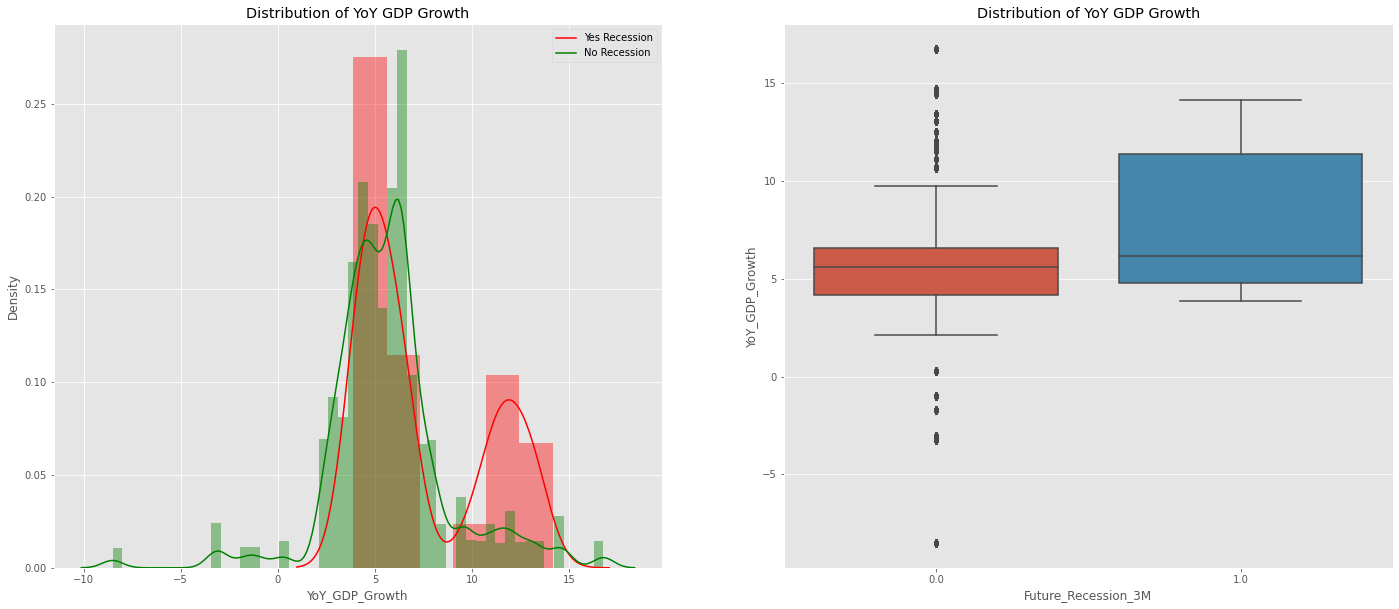

In [1792]:
fig, ax = plt.subplots(1, 2, figsize = (24, 10))

sns.distplot(df_model[df_model["Future_Recession_3M"] == 1]["YoY_GDP_Growth"], color = "red", ax = ax[0])
sns.distplot(df_model[df_model["Future_Recession_3M"] == 0]["YoY_GDP_Growth"], color = "green", ax = ax[0])
ax[0].legend(labels = ["Yes Recession", "No Recession"])
ax[0].set_title("Distribution of YoY GDP Growth")
   
sns.boxplot(data = df_model, x = "Future_Recession_3M", y = "YoY_GDP_Growth", ax = ax[1])
ax[1].set_title("Distribution of YoY GDP Growth")

plt.show()

There appears to be a subset of recessions that are increasingly likley when the GDP growth is particularly high in the pervious reporting

#### Unemployment Rate

C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


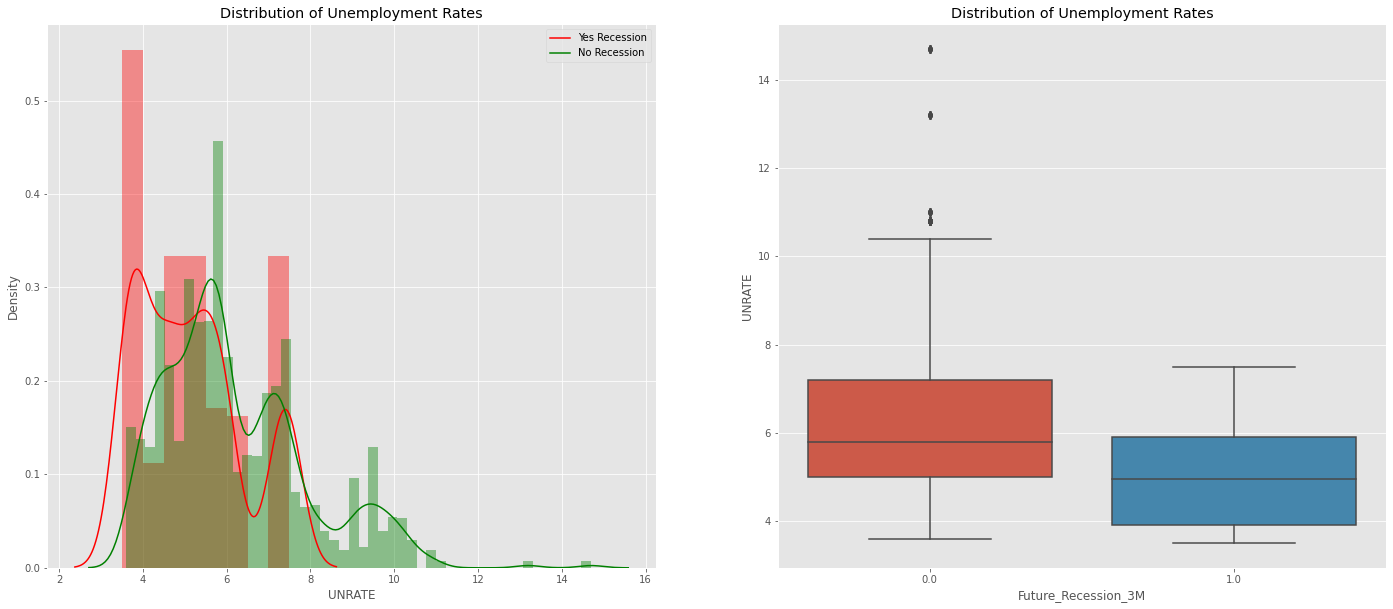

In [1793]:
fig, ax = plt.subplots(1, 2, figsize = (24, 10))

sns.distplot(df_model[df_model["Future_Recession_3M"] == 1]["UNRATE"], color = "red", ax = ax[0])
sns.distplot(df_model[df_model["Future_Recession_3M"] == 0]["UNRATE"], color = "green", ax = ax[0])
ax[0].legend(labels = ["Yes Recession", "No Recession"])
ax[0].set_title("Distribution of Unemployment Rates")
   
sns.boxplot(data = df_model, x = "Future_Recession_3M", y = "UNRATE", ax = ax[1])
ax[1].set_title("Distribution of Unemployment Rates")

plt.show()

Very low unemployment rates appear to be a leading indicator of a future recession, and very high unemployment rates are very unlikely to lead to a near term recession. The latter is likely the result of high unemployment rates at the onset of an expansionary period that follows a recession.

#### Inflation

C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

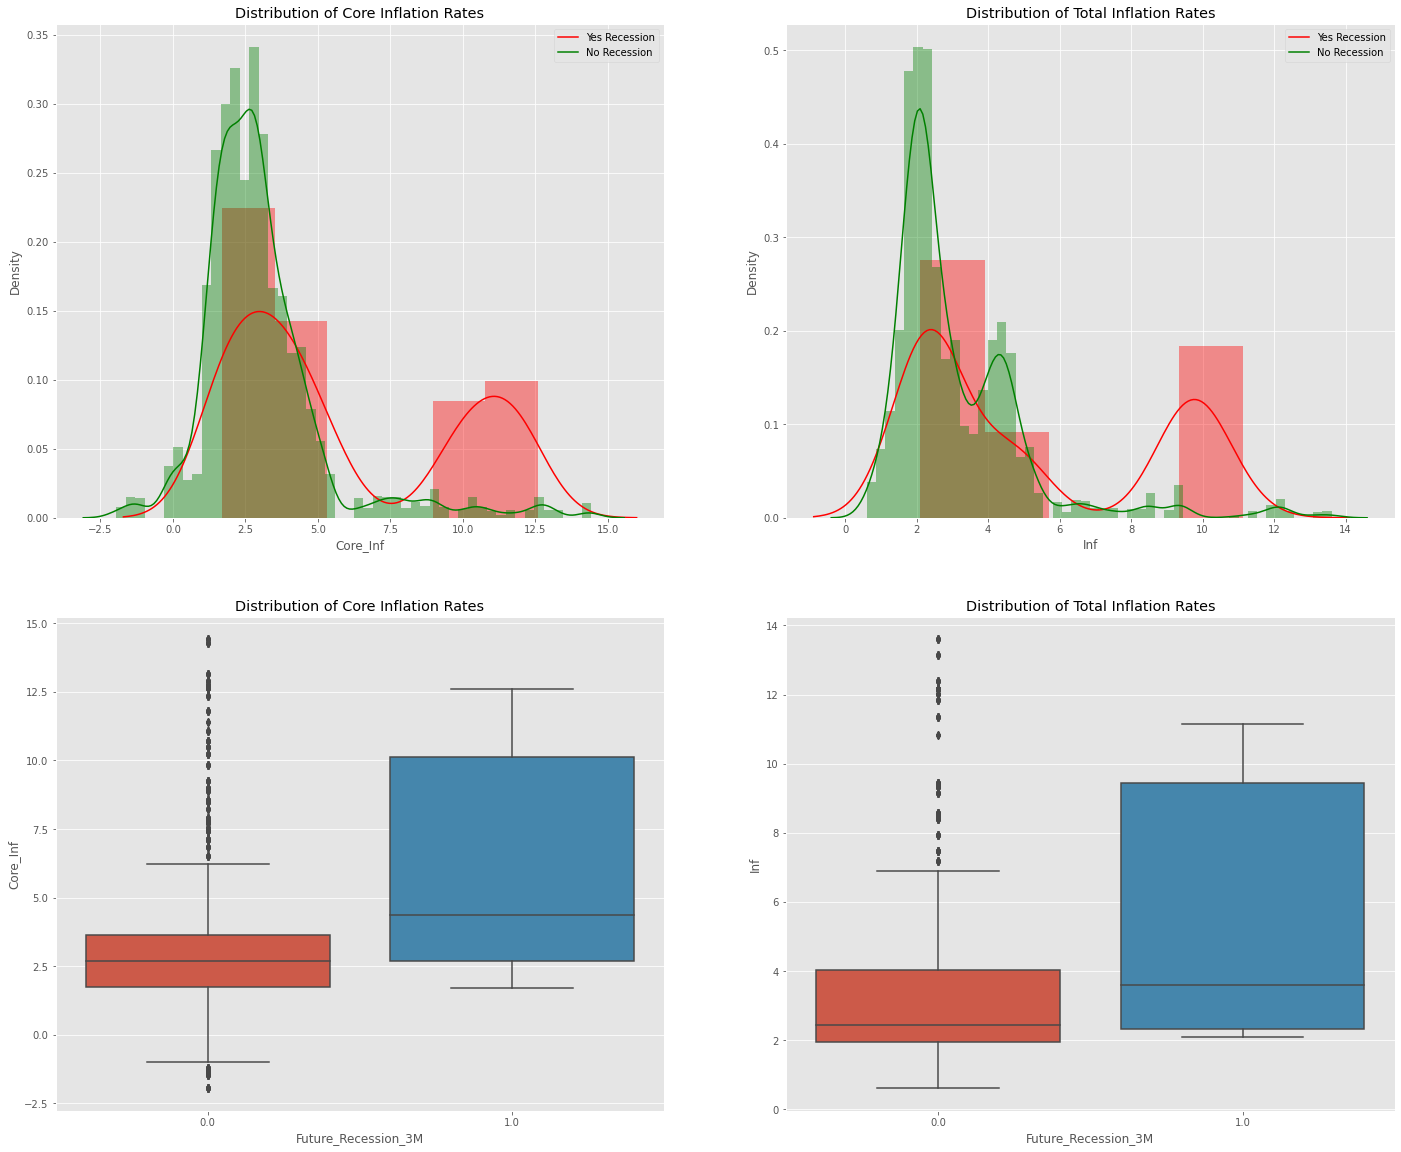

In [1794]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (24, 20))

sns.distplot(df_model[df_model["Future_Recession_3M"] == 1]["Core_Inf"], color = "red", ax = ax1[0])
sns.distplot(df_model[df_model["Future_Recession_3M"] == 0]["Core_Inf"], color = "green", ax = ax1[0])
ax1[0].legend(labels = ["Yes Recession", "No Recession"])
ax1[0].set_title("Distribution of Core Inflation Rates")

sns.distplot(df_model[df_model["Future_Recession_3M"] == 1]["Inf"], color = "red", ax = ax1[1])
sns.distplot(df_model[df_model["Future_Recession_3M"] == 0]["Inf"], color = "green", ax = ax1[1])
ax1[1].legend(labels = ["Yes Recession", "No Recession"])
ax1[1].set_title("Distribution of Total Inflation Rates")

sns.boxplot(data = df_model, x = "Future_Recession_3M", y = "Core_Inf", ax = ax2[0])
ax2[0].set_title("Distribution of Core Inflation Rates")


sns.boxplot(data = df_model, x = "Future_Recession_3M", y = "Inf", ax = ax2[1])
ax2[1].set_title("Distribution of Total Inflation Rates")

plt.show()

A significant subset of recessions appear to follow particularly high rates of inflation, and even the other recessions have inflation rates higher than the apparent median point of days not leading to a recession. 

#### Treasury Yields

C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


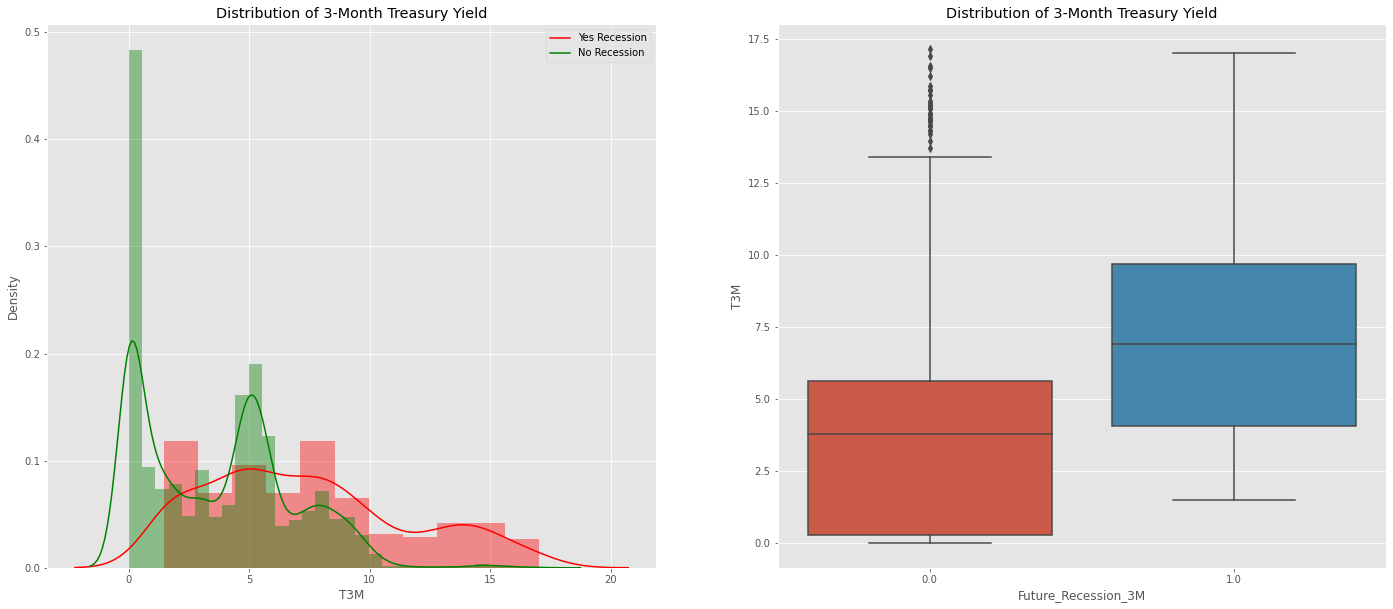

In [1795]:
fig, ax = plt.subplots(1, 2, figsize = (24, 10))

sns.distplot(df_model[df_model["Future_Recession_3M"] == 1]["T3M"], color = "red", ax = ax[0])
sns.distplot(df_model[df_model["Future_Recession_3M"] == 0]["T3M"], color = "green", ax = ax[0])
ax[0].legend(labels = ["Yes Recession", "No Recession"])
ax[0].set_title("Distribution of 3-Month Treasury Yield")
   
sns.boxplot(data = df_model, x = "Future_Recession_3M", y = "T3M", ax = ax[1])
ax[1].set_title("Distribution of 3-Month Treasury Yield")

plt.show()

C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Date_Num', ylabel='Density'>

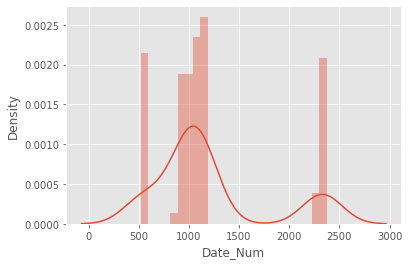

In [1796]:
sns.distplot(df_model[df_model["T3M"] > 10]["Date_Num"])

In [1797]:
df1[(df1["Date_Num"] == 553) | (df1["Date_Num"] == 1001) | (df1["Date_Num"] == 2303)]

,Date,Date_Num,Recession,YoY_GDP_Growth,UNRATE,Core_Inf,Inf,T3M,T30Y-T3M,T10Y-T3M,T5Y-T3M,LTM_SP_Return,Future_Recession_3M,Future_Recession_1Y,Future_Recession_1M
297,1979-10-10,553.0,0.0,9.969281,6.0,12.071535,10.119048,11.74,-2.050000,-1.65,-1.26,0.804139,1.0,0.0,NaN
491,1980-12-31,1001.0,0.0,9.606653,7.2,12.353706,12.153236,14.30,-2.320001,-1.87,-1.71,25.773570,0.0,1.0,NaN
1164,1984-07-25,2303.0,0.0,10.708914,7.5,4.308617,5.210421,10.26,2.710000,2.80,2.69,-12.210227,0.0,0.0,NaN


Once 3M treasury yield exceed 10%, the liklihood of an uncoming recession rise dramatically; however, this was a unique circumstance that occured during the stagflationary period in the late 1970s and eary 1980s.

#### Yield Curve

C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


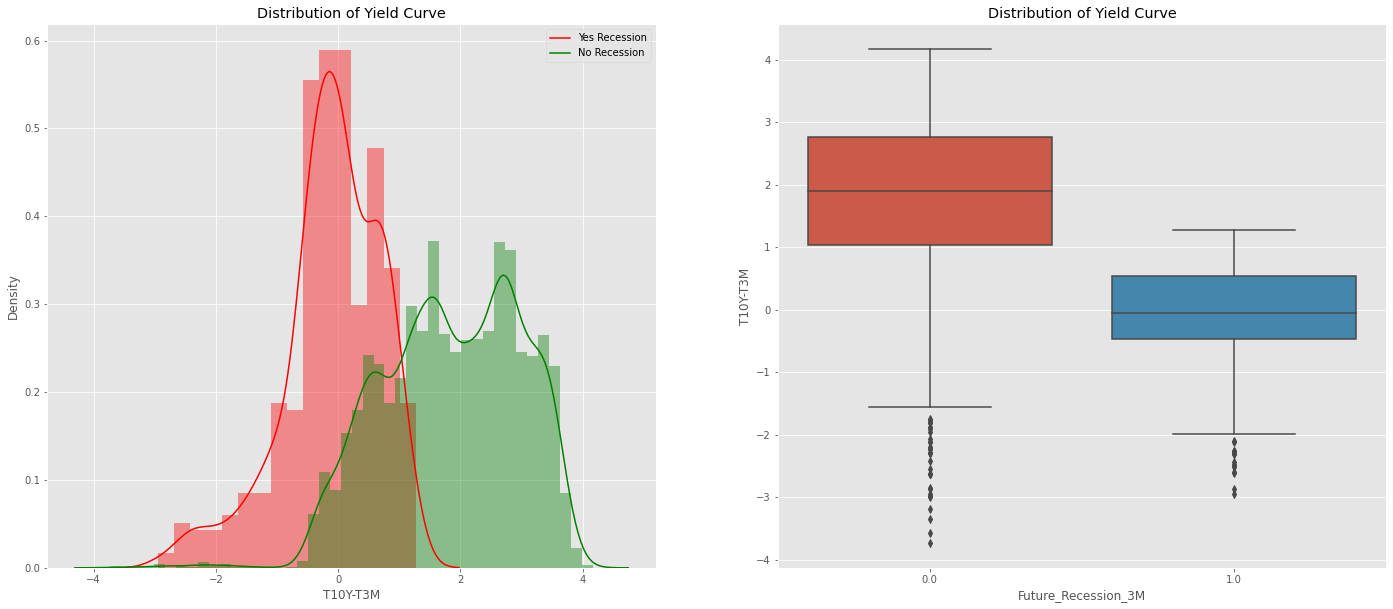

In [1798]:
fig, ax = plt.subplots(1, 2, figsize = (24, 10))

sns.distplot(df_model[df_model["Future_Recession_3M"] == 1]["T10Y-T3M"], color = "red", ax = ax[0])
sns.distplot(df_model[df_model["Future_Recession_3M"] == 0]["T10Y-T3M"], color = "green", ax = ax[0])
ax[0].legend(labels = ["Yes Recession", "No Recession"])
ax[0].set_title("Distribution of Yield Curve")
   
sns.boxplot(data = df_model, x = "Future_Recession_3M", y = "T10Y-T3M", ax = ax[1])
ax[1].set_title("Distribution of Yield Curve")

plt.show()

The yield curve shows that recessions are far more likely when the yield curve is inverted.

#### Date

C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ikant\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


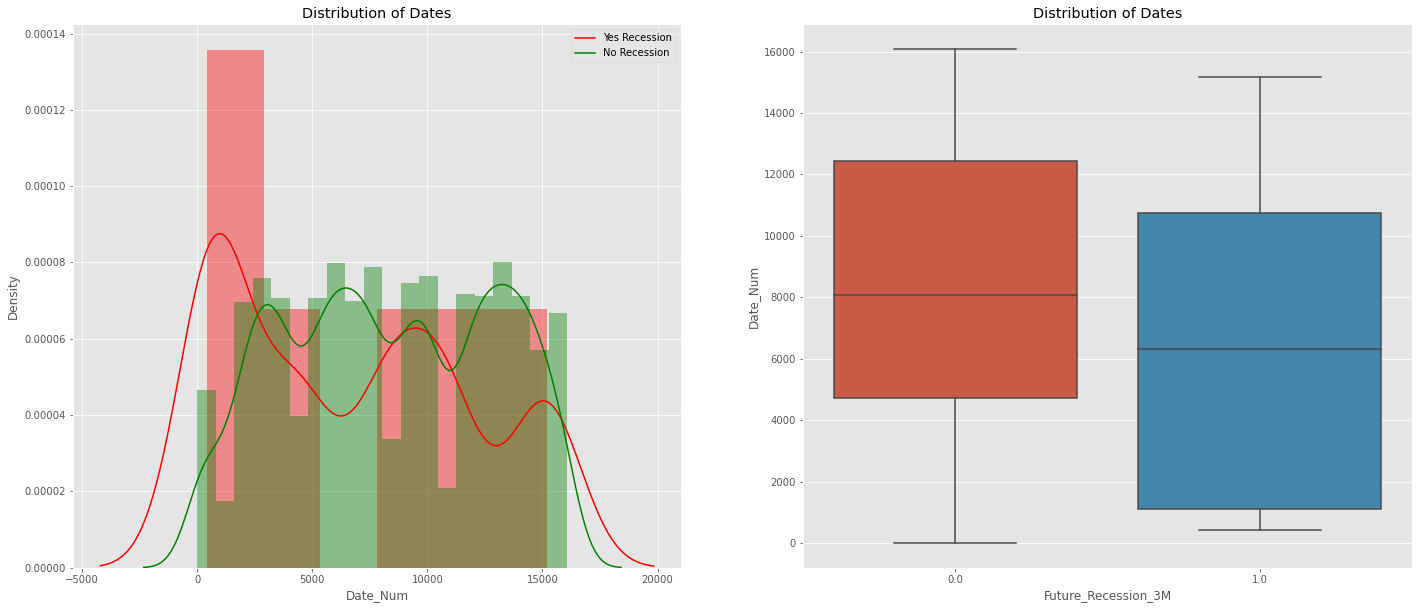

In [1799]:
fig, ax = plt.subplots(1, 2, figsize = (24, 10))

sns.distplot(df_model[df_model["Future_Recession_3M"] == 1]["Date_Num"], color = "red", ax = ax[0])
sns.distplot(df_model[df_model["Future_Recession_3M"] == 0]["Date_Num"], color = "green", ax = ax[0])
ax[0].legend(labels = ["Yes Recession", "No Recession"])
ax[0].set_title("Distribution of Dates")
   
sns.boxplot(data = df_model, x = "Future_Recession_3M", y = "Date_Num", ax = ax[1])
ax[1].set_title("Distribution of Dates")

plt.show()

The number of days in which there has been a recession appears to have decreased over time, but not to a substantial degree.

## Classification 1: 3M Future Recession

#### Define Training / Tesing Data

Testing set will be picked manually to see if the classification algorithms would have been able to predict the recession of the early 1990s (began in June 1990 and ended in March 1991) 

In [1800]:
df_model.isnull().sum()

Date                      0
Date_Num                  0
Recession                 0
YoY_GDP_Growth            0
UNRATE                    0
Core_Inf                  0
Inf                       0
T3M                       0
T30Y-T3M                  0
T10Y-T3M                  0
T5Y-T3M                   0
LTM_SP_Return             0
Future_Recession_3M      74
Future_Recession_1Y       0
Future_Recession_1M    5152
dtype: int64

In [1801]:
df_model1 = df_model.copy()
df_model1.dropna(subset = ["Future_Recession_3M"], inplace = True)
df_model1.isnull().sum()

Date                      0
Date_Num                  0
Recession                 0
YoY_GDP_Growth            0
UNRATE                    0
Core_Inf                  0
Inf                       0
T3M                       0
T30Y-T3M                  0
T10Y-T3M                  0
T5Y-T3M                   0
LTM_SP_Return             0
Future_Recession_3M       0
Future_Recession_1Y       0
Future_Recession_1M    5078
dtype: int64

In [1802]:
print("Test set should be {} rows long".format(round(len(df_model1) * 0.2), 0))

Test set should be 1442 rows long


In [1803]:
test_data1 = df_model1[(df_model1["Date"] > pd.Timestamp(1985, 1, 1)) & (df_model1["Date"] < pd.Timestamp(1993, 8, 15))]
len(test_data1)

1442

In [1804]:
test_data1.head()

,Date,Date_Num,Recession,YoY_GDP_Growth,UNRATE,Core_Inf,Inf,T3M,T30Y-T3M,T10Y-T3M,T5Y-T3M,LTM_SP_Return,Future_Recession_3M,Future_Recession_1Y,Future_Recession_1M
1228,1985-01-03,2465.0,0.0,8.242312,7.3,3.525955,4.487805,7.80,3.84,3.82,3.330000,0.323100,0.0,0.0,NaN
1229,1985-01-04,2466.0,0.0,8.242312,7.3,3.525955,4.487805,7.82,3.88,3.85,3.369999,-1.858740,0.0,0.0,NaN
1230,1985-01-09,2471.0,0.0,8.242312,7.3,3.525955,4.487805,7.69,3.81,3.78,3.340000,-2.202487,0.0,0.0,NaN
1231,1985-01-10,2472.0,0.0,8.242312,7.3,3.525955,4.487805,7.74,3.79,3.74,3.310000,0.214350,0.0,0.0,NaN
1232,1985-01-11,2473.0,0.0,8.242312,7.3,3.525955,4.487805,7.76,3.88,3.83,3.380000,0.065555,0.0,0.0,NaN


In [1805]:
train_data1 = df_model1[(df_model1["Date"] <= pd.Timestamp(1985, 1, 1)) | (df_model1["Date"] >= pd.Timestamp(1993, 8, 15))]
len(train_data1)

5769

In [1806]:
train_data1.head()

,Date,Date_Num,Recession,YoY_GDP_Growth,UNRATE,Core_Inf,Inf,T3M,T30Y-T3M,T10Y-T3M,T5Y-T3M,LTM_SP_Return,Future_Recession_3M,Future_Recession_1Y,Future_Recession_1M
0,1978-04-05,0.0,0.0,13.411294,6.1,6.5,6.633499,6.42,1.90,1.72,1.55,-8.539948,0.0,0.0,0.0
1,1978-04-06,1.0,0.0,13.411294,6.1,6.5,6.633499,6.41,1.92,1.75,1.57,-8.293333,0.0,0.0,NaN
2,1978-04-07,2.0,0.0,13.411294,6.1,6.5,6.633499,6.34,2.00,1.80,1.63,-8.317235,0.0,0.0,NaN
3,1978-04-11,6.0,0.0,13.411294,6.1,6.5,6.633499,6.35,2.00,1.81,1.62,-8.727748,0.0,0.0,0.0
4,1978-04-12,7.0,0.0,13.411294,6.1,6.5,6.633499,6.33,2.02,1.83,1.64,-10.024963,0.0,0.0,0.0


In [1807]:
len(test_data1) / len(train_data1)

0.249956664933264

In [1816]:
x_train1 = train_data1.drop(["Date", "Recession", "Future_Recession_3M", "Future_Recession_1Y", "Future_Recession_1M"], axis = 1).values
y_train1 = train_data1["Future_Recession_3M"].values

x_test1 = test_data1.drop(["Date", "Recession", "Future_Recession_3M", "Future_Recession_1Y", "Future_Recession_1M"], axis = 1).values
y_test1 = test_data1["Future_Recession_3M"].values

In [1817]:
print("Training:", len(x_train1))
print("Testing:", len(x_test1))

Training: 5769
Testing: 1442


#### Create Standardized Data Sets

In [1818]:
from sklearn.preprocessing import StandardScaler

In [1819]:
x_train_norm1 = StandardScaler().fit_transform(x_train1)
x_test_norm1 = StandardScaler().fit_transform(x_test1)

#### Clustering Analysis

In [1820]:
from sklearn.cluster import KMeans
import scikitplot as skplt

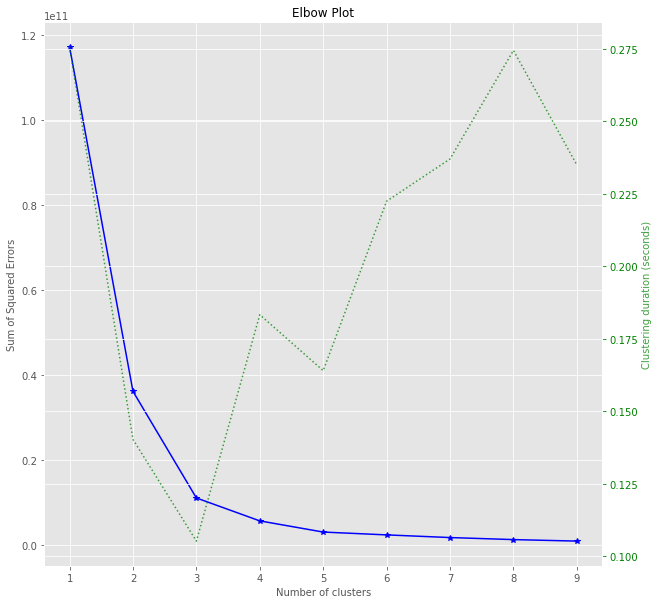

In [1821]:
kmeans = KMeans(random_state = 42)

skplt.cluster.plot_elbow_curve(kmeans, x_train1, cluster_ranges = range(1, 10), n_jobs = -1, figsize = (10, 10))

plt.show()

The elbow plot shows that the ideal number of clusters is 3

In [1822]:
kmeans = KMeans(n_clusters = 3, random_state = 42).fit(x_train1)

In [1823]:
df_clust = train_data1.copy()
df_clust["Cluster"] = kmeans.labels_

for i in range(3):
    print("Label:", np.unique(kmeans.labels_, return_counts = True)[0][i])
    print("Counts:", np.unique(kmeans.labels_, return_counts = True)[1][i])
    print("")

Label: 0
Counts: 895

Label: 1
Counts: 2524

Label: 2
Counts: 2350



In [1824]:
df_clust.groupby("Cluster").mean().sort_values("Future_Recession_3M", ascending = False)

,Date_Num,Recession,YoY_GDP_Growth,UNRATE,Core_Inf,Inf,T3M,T30Y-T3M,T10Y-T3M,T5Y-T3M,LTM_SP_Return,Future_Recession_3M,Future_Recession_1Y,Future_Recession_1M
Cluster,,,,,,,,,,,,,,
0,1206.039106,0.0,10.651984,7.569497,7.455429,7.332679,9.542950,1.185128,1.249263,1.159073,14.289547,0.165363,0.188827,0.048193
1,8197.937797,0.0,5.559473,5.154834,2.562279,2.359964,3.894146,1.841162,1.477851,1.138094,11.511062,0.058637,0.068542,0.012788
2,13648.064681,0.0,4.006231,6.463660,2.022887,2.063305,0.463265,2.623863,1.860080,1.128694,13.026939,0.031489,0.022128,0.004418


In [1825]:
df_clust.groupby("Cluster").std().sort_values("Future_Recession_3M", ascending = False)

,Date_Num,Recession,YoY_GDP_Growth,UNRATE,Core_Inf,Inf,T3M,T30Y-T3M,T10Y-T3M,T5Y-T3M,LTM_SP_Return,Future_Recession_3M,Future_Recession_1Y,Future_Recession_1M
Cluster,,,,,,,,,,,,,,
0,799.673671,0.0,2.867698,1.587873,3.640236,2.887269,2.262516,1.798076,1.658483,1.456573,15.295752,0.371716,0.391590,0.214605
1,1553.759618,0.0,1.134625,0.725819,0.729234,0.461947,1.584543,1.366638,1.157295,0.889818,15.351761,0.234991,0.252724,0.112429
2,1369.366821,0.0,3.543375,2.266719,1.730891,1.002283,0.726247,1.145159,0.937863,0.644232,13.606475,0.174673,0.147130,0.066372


Clustering shows 3 natural segments (in order of mean likelihood of a future recession):
* **Cluster 0:** 70-80s volatile but high growth, inflation, and rates with highest likelihood of a recession
* **Cluster 1:** 90s and pre financial crisis period of low volatility in economic metrics around 4-6% growth, 4-6% unemployment, low and stable inflation around 2-3%, with medium likelihood of a recession
* **Cluster 2:** post-2008 financial crisis low growth, low rates, low inflation, and a low liklihood of recession

#### Classification

First determine the zero rate (ZeroR = rate of predictive success when prediction always classifies the most common class) as a baseline rate with which to compare the classification models.

In [1826]:
train_zero_rate1 = 1 - round(len(train_data1[train_data1["Future_Recession_3M"] == 1]) / len(train_data1), 2)
print("Training ZeroR = {:.1%}".format(train_zero_rate1))

test_zero_rate1 = 1 - round(len(test_data1[test_data1["Future_Recession_3M"] == 1]) / len(test_data1), 2)
print("Test ZeroR = {:.1%}".format(test_zero_rate1))

Training ZeroR = 94.0%
Test ZeroR = 95.0%


In [1827]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score

In [1828]:
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Classifier": SVC(),
    "Linear Support Vector Classifier": LinearSVC(),
    "RandomForestClassifier": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian": GaussianNB(),
    "Perceptron": Perceptron(),
    "SGD Classifier": SGDClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier()
}

In [1829]:
train_acc1 = []
train_acc_norm1 = []

for name, classifier in classifiers.items():
    classifier.fit(x_train1, y_train1)
    training_accuracy = cross_val_score(classifier, x_train1, y_train1, cv = 5)
    
    classifier.fit(x_train_norm1, y_train1)
    training_accuracy_norm = cross_val_score(classifier, x_train_norm1, y_train1, cv = 5)
    
    train_acc_norm1.append(round(training_accuracy_norm.mean(), 2))
    train_acc1.append(round(training_accuracy.mean(), 2))

C:\Users\ikant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ikant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [1830]:
print("Training Accuracy")
print("")

for (name, classifier), acc in zip(classifiers.items(), train_acc1):
    print(name, ":", acc)

print("")

print("Training Accuracy: Standardized")
print("")

for (name, classifier), acc in zip(classifiers.items(), train_acc_norm1):
    print(name, ":", acc)

Training Accuracy

Logistic Regression : 0.92
Support Vector Classifier : 0.82
Linear Support Vector Classifier : 0.53
RandomForestClassifier : 0.8
K-Nearest Neighbors : 0.65
Gaussian : 0.86
Perceptron : 0.92
SGD Classifier : 0.91
Decision Tree Classifier : 0.64

Training Accuracy: Standardized

Logistic Regression : 0.9
Support Vector Classifier : 0.71
Linear Support Vector Classifier : 0.91
RandomForestClassifier : 0.81
K-Nearest Neighbors : 0.74
Gaussian : 0.86
Perceptron : 0.84
SGD Classifier : 0.86
Decision Tree Classifier : 0.64


None of the classifiers have a training accuracy greater than the ZeroR rate for the training or testing set, indicating that none of the classifiers are better at classifying 3-month future recessions than merely always predicting no future recession (94% training accuracy, 95% testing accuracy).

## Classification 2: 1Y Future Recession

In [1831]:
df_model2 = df_model.copy()
df_model2.dropna(subset = ["Future_Recession_1Y"], inplace = True)
df_model2.isnull().sum()

Date                      0
Date_Num                  0
Recession                 0
YoY_GDP_Growth            0
UNRATE                    0
Core_Inf                  0
Inf                       0
T3M                       0
T30Y-T3M                  0
T10Y-T3M                  0
T5Y-T3M                   0
LTM_SP_Return             0
Future_Recession_3M      74
Future_Recession_1Y       0
Future_Recession_1M    5152
dtype: int64

In [1832]:
print("Test set should be {} rows long".format(round(len(df_model2) * 0.2), 0))

Test set should be 1457 rows long


In [1833]:
test_data2 = df_model2[(df_model2["Date"] > pd.Timestamp(1985, 1, 1)) & (df_model2["Date"] < pd.Timestamp(1993, 8, 15))]
len(test_data2)

1442

In [1834]:
train_data2 = df_model2[(df_model2["Date"] <= pd.Timestamp(1985, 1, 1)) | (df_model2["Date"] >= pd.Timestamp(1993, 8, 15))]
len(train_data2)

5843

In [1835]:
x_train2 = train_data2.drop(["Date", "Recession", "Future_Recession_3M", "Future_Recession_1Y", "Future_Recession_1M"], axis = 1).values
y_train2 = train_data2["Future_Recession_1Y"].values

x_test2 = test_data2.drop(["Date", "Recession", "Future_Recession_3M", "Future_Recession_1Y", "Future_Recession_1M"], axis = 1).values
y_test2 = test_data2["Future_Recession_1Y"].values

In [1836]:
print("Training:", len(x_train2))
print("Testing:", len(x_test2))

Training: 5843
Testing: 1442


In [1837]:
x_train_norm2 = StandardScaler().fit_transform(x_train2)
x_test_norm2 = StandardScaler().fit_transform(x_test2)

In [1838]:
train_zero_rate2 = 1 - round(len(train_data2[train_data2["Future_Recession_1Y"] == 1]) / len(train_data2), 2)
print("Training ZeroR = {:.1%}".format(train_zero_rate2))

test_zero_rate2 = 1 - round(len(test_data2[test_data2["Future_Recession_1Y"] == 1]) / len(test_data2), 2)
print("Test ZeroR = {:.1%}".format(test_zero_rate2))

Training ZeroR = 93.0%
Test ZeroR = 93.0%


In [1839]:
train_acc2 = []
train_acc_norm2 = []

for name, classifier in classifiers.items():
    classifier.fit(x_train2, y_train2)
    training_accuracy = cross_val_score(classifier, x_train2, y_train2, cv = 5)
    
    classifier.fit(x_train_norm2, y_train2)
    training_accuracy_norm = cross_val_score(classifier, x_train_norm2, y_train2, cv = 5)
    
    train_acc_norm2.append(round(training_accuracy_norm.mean(), 2))
    train_acc2.append(round(training_accuracy.mean(), 2))

C:\Users\ikant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ikant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [1840]:
print("Training Accuracy")
print("")

for (name, classifier), acc in zip(classifiers.items(), train_acc2):
    print(name, ":", acc)

print("")

print("Training Accuracy: Standardized")
print("")

for (name, classifier), acc in zip(classifiers.items(), train_acc_norm2):
    print(name, ":", acc)

Training Accuracy

Logistic Regression : 0.91
Support Vector Classifier : 0.82
Linear Support Vector Classifier : 0.66
RandomForestClassifier : 0.76
K-Nearest Neighbors : 0.65
Gaussian : 0.87
Perceptron : 0.91
SGD Classifier : 0.73
Decision Tree Classifier : 0.71

Training Accuracy: Standardized

Logistic Regression : 0.77
Support Vector Classifier : 0.8
Linear Support Vector Classifier : 0.78
RandomForestClassifier : 0.82
K-Nearest Neighbors : 0.8
Gaussian : 0.87
Perceptron : 0.73
SGD Classifier : 0.69
Decision Tree Classifier : 0.83


None of the classifiers have a training accuracy greater than the ZeroR rate for the training or testing set, indicating that none of the classifiers are better at classifying 1-year future recessions than merely always predicting no future recession (93% training accuracy, 93% testing accuracy).

## Classification 3: 1M Future Recession

In [1841]:
df_model3 = df_model.copy()
df_model3.dropna(subset = ["Future_Recession_1M"], inplace = True)
df_model3.isnull().sum()

Date                   0
Date_Num               0
Recession              0
YoY_GDP_Growth         0
UNRATE                 0
Core_Inf               0
Inf                    0
T3M                    0
T30Y-T3M               0
T10Y-T3M               0
T5Y-T3M                0
LTM_SP_Return          0
Future_Recession_3M    0
Future_Recession_1Y    0
Future_Recession_1M    0
dtype: int64

In [1842]:
print("Test set should be {} rows long".format(round(len(df_model3) * 0.2), 0))

Test set should be 427 rows long


In [1843]:
test_data3 = df_model3[(df_model3["Date"] > pd.Timestamp(1985, 1, 1)) & (df_model3["Date"] < pd.Timestamp(1993, 8, 15))]
len(test_data3)

423

In [1844]:
train_data3 = df_model3[(df_model3["Date"] <= pd.Timestamp(1985, 1, 1)) | (df_model3["Date"] >= pd.Timestamp(1993, 8, 15))]
len(train_data3)

1710

In [1847]:
x_train3 = train_data3.drop(["Date", "Recession", "Future_Recession_3M", "Future_Recession_1Y", "Future_Recession_1M"], axis = 1).values
y_train3 = train_data3["Future_Recession_1M"].values

x_test3 = test_data3.drop(["Date", "Recession", "Future_Recession_3M", "Future_Recession_1Y", "Future_Recession_1M"], axis = 1).values
y_test3 = test_data3["Future_Recession_1M"].values

In [1848]:
print("Training:", len(x_train3))
print("Testing:", len(x_test3))

Training: 1710
Testing: 423


In [1849]:
x_train_norm3 = StandardScaler().fit_transform(x_train3)
x_test_norm3 = StandardScaler().fit_transform(x_test3)

In [1852]:
train_zero_rate3 = 1 - round(len(train_data3[train_data3["Future_Recession_1M"] == 1]) / len(train_data3), 2)
print("Training ZeroR = {:.1%}".format(train_zero_rate3))

test_zero_rate3 = 1 - round(len(test_data3[test_data3["Future_Recession_1M"] == 1]) / len(test_data3), 2)
print("Test ZeroR = {:.1%}".format(test_zero_rate3))

Training ZeroR = 99.0%
Test ZeroR = 99.0%


In [1850]:
train_acc3 = []
train_acc_norm3 = []

for name, classifier in classifiers.items():
    classifier.fit(x_train3, y_train3)
    training_accuracy = cross_val_score(classifier, x_train3, y_train3, cv = 5)
    
    classifier.fit(x_train_norm3, y_train3)
    training_accuracy_norm = cross_val_score(classifier, x_train_norm3, y_train3, cv = 5)
    
    train_acc_norm3.append(round(training_accuracy_norm.mean(), 2))
    train_acc3.append(round(training_accuracy.mean(), 2))

C:\Users\ikant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ikant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [1851]:
print("Training Accuracy")
print("")

for (name, classifier), acc in zip(classifiers.items(), train_acc3):
    print(name, ":", acc)

print("")

print("Training Accuracy: Standardized")
print("")

for (name, classifier), acc in zip(classifiers.items(), train_acc_norm3):
    print(name, ":", acc)

Training Accuracy

Logistic Regression : 0.92
Support Vector Classifier : 0.85
Linear Support Vector Classifier : 0.79
RandomForestClassifier : 0.93
K-Nearest Neighbors : 0.66
Gaussian : 0.91
Perceptron : 0.98
SGD Classifier : 0.96
Decision Tree Classifier : 0.88

Training Accuracy: Standardized

Logistic Regression : 0.93
Support Vector Classifier : 0.95
Linear Support Vector Classifier : 0.92
RandomForestClassifier : 0.93
K-Nearest Neighbors : 0.89
Gaussian : 0.91
Perceptron : 0.86
SGD Classifier : 0.92
Decision Tree Classifier : 0.88


None of the classifiers have a training accuracy greater than the ZeroR rate for the training or testing set, indicating that none of the classifiers are better at classifying 1-month future recessions than merely always predicting no future recession (99% training accuracy, 99% testing accuracy).